## DQN Training
This is the first experiment using the CartPole environment. The experiments in CartPole act as a tutorial on how to use our code and all the other experiments are based upon them, so this provides a good starting point if you want to run your own experiments. 
The tutorials build upon each other and it is recommended to follow them in the following order:
1. DQN-Training (How to train a conventional DQN and a spiking DQN using Surrogate Gradients (DSQN).)
2. Load-DQN (How to load a previously saved D(S)QN and how to save a replay dataset.)
3. Train-Classifier (How to train a spiking or non-spiking classifier on the saved replay data set.)
4. SNN-Conversion (How to convert a DQN and a Classifier to a SNN.)
5. Load in NEST (How to load a converted or directly trained spiking network in NEST.)
6. Conversion in pyNN with NEST or SpyNNaker (How to load spiking network in pyNN using NEST or SpyNNaker as backend.)

In this first part we train a DQN (non-spiking and spiking) on the CartPole problem. At the same time this file serves as a tutorial for training DQNs with any environment.

In [1]:
import torch
import torch.optim as optim
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../../')
from Code import train_agent, SQN, FullyConnected

We start with setting up the result directory.
<div class="alert alert-block alert-warning">
<b>Attention:</b> If the directory with the specified name already exists, this will throw an error. You need to specify a different name or delete the old directory. If this happens, you should restart the kernel, as the directory is a relative path which changes everytime this cell is run.
</div>

In [2]:
# switch to the Result Directory
os.chdir('./../../Results/')
# choose the name of the result directory
result_directory = 'CartPole-Experiment1-DQN-Training'
# create the result directory (throws an error if the directory already exists)
os.makedirs(result_directory)
os.chdir(result_directory)
# for the first experiment we create an additinonal sub folder
os.makedirs('DQN')
os.chdir('DQN')

We define the seeds, hyperparameters and initial weights to values that reached the Open AI gym standard succesfully. This should make the results fairly reproducible. In our thesis we additionally specify the versions of the most important libraries we are using, but there is likely something we missed that might still make the results not exactly reproducible. However, we believe that reporting as many parameters as possible, reproducibility becomes much easier. For example reporting hyperparameters alone can make the results difficult to reproduce, because the training performance is also strongly dependent on random seeds and initial weights.

In [3]:
torch_seed = 135
torch.manual_seed(torch_seed)
random_seed = 795
random.seed(random_seed)
gym_seed = 975

Next, we define the environment and all the hyperparameters for a non-spiking Q-network. We then set up the result directory. 

In [4]:
#CartPole
env = 'CartPole-v0'

#hyperparameters
BATCH_SIZE = 128
DISCOUNT_FACTOR = 0.999
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.999
TARGET_UPDATE_FREQUENCY = 10
LEARNING_RATE = 0.001
REPLAY_MEMORY_SIZE = 4*10**4
# minimum size of the replay memory before the training starts
INITIAL_REPLAY_SIZE = 0
# the gym standard for CartPole ("solving" it) is to achieve a 100-episode average of <=195 for 100 consecutive episodes
GYM_TARGET_AVG = 195
GYM_TARGET_DURATION = 100
# maximum number of steps before the environment is reset
MAX_STEPS = 200
# number of episodes to train the agent
NUM_EPISODES = 1000
# whether to use Double Q Learning and Gradient Clipping
DOUBLE_Q = True
GRADIENT_CLIPPING = True
# whether to render the environment
RENDER = True

# device: automatically runs on GPU, if a GPU is detected, else uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Next we initialize the neural network for the problem: We use a Fully-Connected network with two hidden layers with 16 neurons each and ReLu activations. The size of the in- and output layers is determined by the environment. 
The target net initially is a copy of the policy net.
Then we set up the optimizer: We use Adam using the specified learning and rate and the standard parameters for everything else.
To make the results reproducible, we load the initial weights of a saved model (they were then initialized at random). Normally the weights would be initialized randomly, this can be done simply by removing the load line.

In [5]:
# initialize policy and target net
# this creates a network with 4 input neurons, two hidden layers with 16 neurons each and two output neurons
architecture = [4,16,16,2] 
policy_net = FullyConnected(architecture).to(device)
# initial weights are actually fixed through the seed
# load the fixed initial weights, remove this line to get random initial weights, not necessary if torch seed is specified
#policy_net.load_state_dict(torch.load('./../../CartPole-v0/DQN/initial/model.pt'))

target_net = FullyConnected(architecture).to(device)
target_net.load_state_dict(policy_net.state_dict())

# initialize optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)



We now train the agent with the specified hyperparameters using the function from Code/train_agent. In the plot, blue shows the individual reward on each episode, while orange shows the average reward over the last 100 episodes.

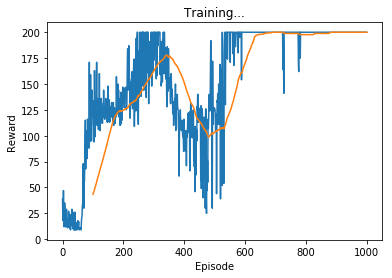

OpenAIGymStandard reached at episode  730
Best average:  tensor(200.)  reached at episode  689
Complete


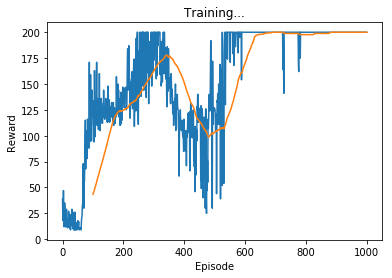

In [6]:
train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed, torch_seed=torch_seed, random_seed=random_seed)

The figure above shows the training progress of the model. Once the Open AI gym standard is reached, the model is saved
in the result directory as trained/model.pt. Additionally, before the training starts the initial weights and the hyperparameters are saved.

### Training of a spiking DQN or DSQN
Next, we train a DSQN using the same hyperparameters as far as possible. That is, all hyperparameters are the same, but we need to define some additional hyperparameters. We adapted the surrogate gradient algorithm we use for the direct training from the SpyTorch jupyter notebooks (available from https://github.com/fzenke/spytorch as of 06.12.2019).

In [7]:
# First we set up a new sub directory
os.chdir('./..')
os.makedirs('DSQN')
os.chdir('DSQN')
# We use a non-leaky integrate-and-fire neuron
ALPHA = 0
BETA = 1
# Simulation time is chosen relatively short, such that the network does not need too much time to run, but not too short,
# such that it can still learn something
SIMULATION_TIME = 20
# We also have to define the input/output and reset methods, to our knowledge, SpyTorch supports only potential outputs 
# and reset-by-subtraction. As input method we use constant input currents. It would be interesting to see if SpyTorch
# can also use reset-to-zero, as this would make it more similar to the iaf_delta models in NEST and SpyNNaker
ENCODING = 'constant'
DECODING = 'potential'
RESET = 'subtraction'
# SpyTorch uses a fixed threshold of one, we didn't test other thresholds, but should be possible
THRESHOLD = 1

We again set the seeds in a way such that the gym standard is reached. We obtained those seed from our experiments, where we saved the seeds upon succesfully reaching the gym standard.

In [8]:
# alternatively use the seeds gym: 240, torch: 18, random: 626 and a learning rate of 0.0005 
# to get the same results as figure 4.9 in the thesis
torch.manual_seed(467)
random.seed(208)
gym_seed = 216


Now, we set up the neural network. Note, that SpyTorch does not support biases, so we instead add a constant input to each observation (equivalent to first layer biases) and add one additional neuron to each hidden layer to compensate for the missing biases.
We then again load a fixed set of weights to make the results reproducible.

In [9]:
architecture = [4,17,17,2]
policy_net = SQN(architecture,device,alpha=ALPHA,beta=BETA,simulation_time=SIMULATION_TIME,add_bias_as_observation=True,
                  encoding=ENCODING,decoding=DECODING,reset=RESET,threshold=THRESHOLD)
# load the fixed initial weights, remove this line to get random initial weights
#policy_net.load_state_dict(torch.load('./../../CartPole-v0/DSQN-Surrogate-Gradients/initial/model.pt'))

target_net = SQN(architecture,device,alpha=0,beta=1,simulation_time=SIMULATION_TIME,add_bias_as_observation=True,
                  encoding=ENCODING,decoding=DECODING,reset=RESET,threshold=THRESHOLD)
target_net.load_state_dict(policy_net.state_dict())

# initialize optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

In the next cell, the agent is trained. The function we use, is exactly the same as for the DQN, the only difference is that the model we pass now is an instance of our SQN class, rather than the PyTorch neural network base class.

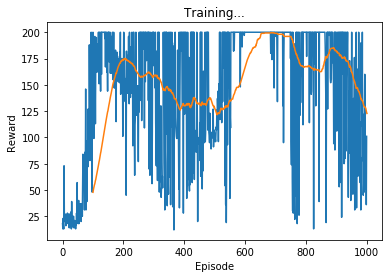

OpenAIGymStandard reached at episode  749
Best average:  tensor(199.6300)  reached at episode  685
Complete


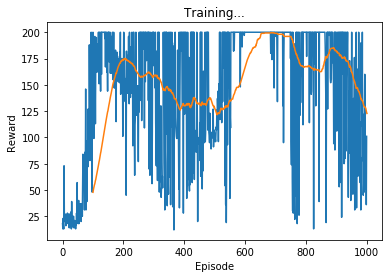

In [10]:
train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed)

The plot again shows the rewards in each episode (blue) and the average reward over the last 100 episodes (orange).

The next experiment in this series is Load-DQN.